In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import cv2
import os
import matplotlib.pyplot as plt
import shutil
import random
from skimage import io
from PIL import Image
import numpy as np

Checking if cuda is available : 

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use GPU!")
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch will use CPU.")


CUDA is available. PyTorch can use GPU!
CUDA Device Name: NVIDIA GeForce GTX 1660


Getting all the data from the old folder and putting it in a new folder where it is randomized and split 80% train, 10% validation and 10% test this step is done because in the data given validation set is only 16 images which is not enogh to validate the data so this step is done to improve preformance of the model :

In [3]:
# Define the paths to the dataset
dataset_path = r"C:\Users\20100\Desktop\PneumoniaML\chest_xray"
new_dataset_path = r"C:\Users\20100\Desktop\PneumoniaML\chest_xray_new"

# Ensure the new dataset directory exists and create subdirectories for each split and class
if not os.path.exists(new_dataset_path):
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    # Distribute files into the new structure
    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Shuffle the list to ensure random distribution
        random.shuffle(all_files)

        # Split files into new train, val, and test sets
        num_files = len(all_files)
        train_files = all_files[:int(num_files * 0.8)]
        val_files = all_files[int(num_files * 0.8):int(num_files * 0.9)]
        test_files = all_files[int(num_files * 0.9):]

        # Copy files to the new directory structure
        for file, source_folder in train_files:
            dest = os.path.join(new_dataset_path, 'train', cls, file)
            shutil.copy(os.path.join(source_folder, file), dest)

        for file, source_folder in val_files:
            dest = os.path.join(new_dataset_path, 'val', cls, file)
            shutil.copy(os.path.join(source_folder, file), dest)

        for file, source_folder in test_files:
            dest = os.path.join(new_dataset_path, 'test', cls, file)
            shutil.copy(os.path.join(source_folder, file), dest)


Visualizing some Data :

In [4]:
def view_random_image(target_directory, target_class):
    target_folder = os.path.join(target_directory, target_class)
    random_image = random.sample(os.listdir(target_folder), 1)[0]
    img = cv2.imread(os.path.join(target_folder, random_image))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    return img

In [5]:
data_direct = os.path.join(new_dataset_path,'train')
class_names=os.listdir(data_direct)
print(class_names)

['NORMAL', 'PNEUMONIA']


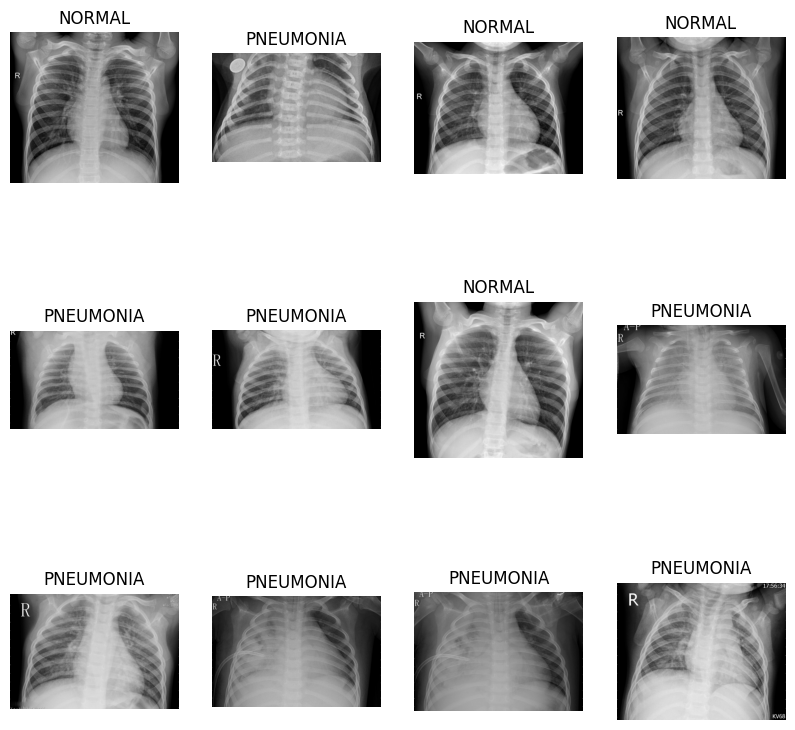

In [6]:
plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    r=random.randint(0,1)
    img = view_random_image(data_direct, class_names[r]) 

Bar ploting different directories

In [7]:
def perform_eda_image_dataset(normal_dir, pneumonia_dir):
    # Count the number of images in each class
    num_normal_images = len(os.listdir(normal_dir))
    num_pneumonia_images = len(os.listdir(pneumonia_dir))

    print(f"Number of normal images: {num_normal_images}")
    print(f"Number of pneumonia images: {num_pneumonia_images}")

    # Visualize class distribution
    plt.figure(figsize=(6, 4))
    plt.bar(["Normal", "Pneumonia"], [num_normal_images, num_pneumonia_images],color="darkgrey")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution")
    plt.show()

Bar plot for Train :

Number of normal images: 1266
Number of pneumonia images: 3418


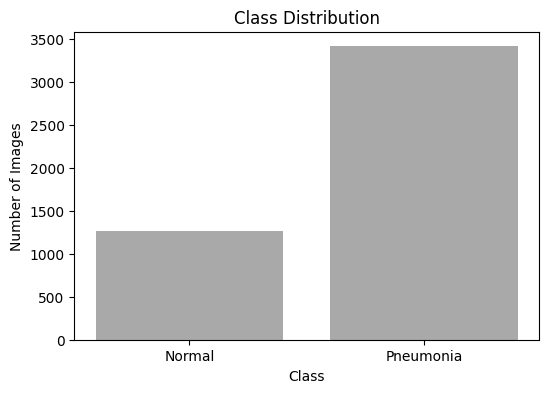

In [8]:
perform_eda_image_dataset(os.path.join(data_direct,"NORMAL"), os.path.join(data_direct,"PNEUMONIA"))

Bar plot for Validation set : 

Number of normal images: 158
Number of pneumonia images: 427


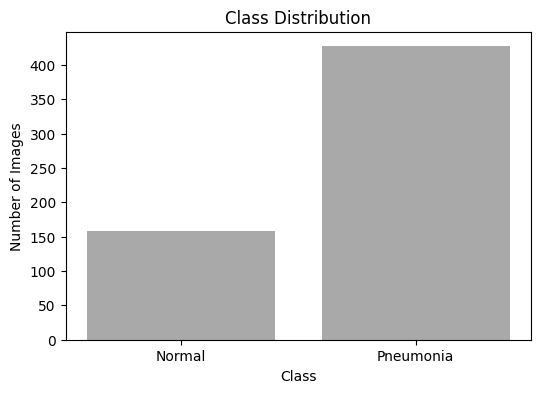

In [9]:
perform_eda_image_dataset(os.path.join(os.path.join(new_dataset_path,'val'),"NORMAL"), os.path.join(os.path.join(new_dataset_path,'val'),"PNEUMONIA"))

Bar plot for Test set : 

Number of normal images: 159
Number of pneumonia images: 428


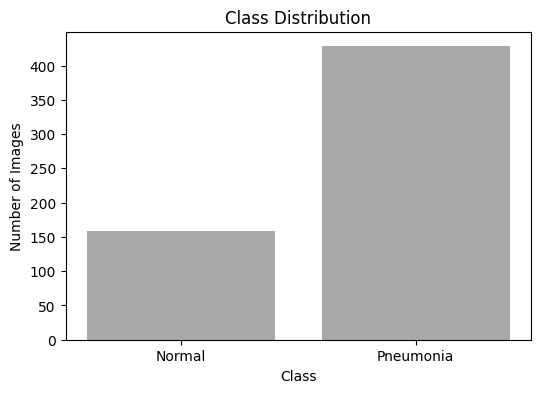

In [10]:
perform_eda_image_dataset(os.path.join(os.path.join(new_dataset_path,'test'),"NORMAL"), os.path.join(os.path.join(new_dataset_path,'test'),"PNEUMONIA"))

Loading the data and applying transforms to it : 

In [11]:
def load_data(data_dir, batch_size=32):
    # Define the transformations for the images.
    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert image to grayscale
        transforms.Resize((224, 224)),  # Resize the image to 224x224
        transforms.ToTensor(),  # Convert the image to a Tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the images
    ])

    # Create a dictionary of datasets, one for each type ('train', 'val', 'test')
    data_folders = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transform)
                    for x in ['train', 'val', 'test']}

    # Create a dictionary of DataLoader to handle each dataset
    dataloaders = {x: DataLoader(data_folders[x], batch_size=batch_size, shuffle=True, num_workers=4)
                   for x in ['train', 'val', 'test']}

    return dataloaders

# Use the function to get dataloaders
data_dir = r"C:\Users\20100\Desktop\PneumoniaML\chest_xray_new"  # This should be the path to the 'chest_xray_new' directory
dataloaders = load_data(data_dir)

# Example usage
for images, labels in dataloaders['train']:
    print(images.shape, labels.shape)
    break

torch.Size([32, 1, 224, 224]) torch.Size([32])


Fully connected neural network :

In [12]:
class FCNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_list):
        super(FCNN, self).__init__()
        self.flatten = nn.Flatten()  # Add flatten operation to ensure input is a 1D vector

        # Define the hidden layers
        layers = []
        in_features = input_size
        for hidden_units in hidden_list:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.4))
            in_features = hidden_units
        layers.append(nn.Linear(hidden_list[-1], num_classes))
        # Create the network using Sequential
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input first
        return self.net(x)


# Calculate the input size based on the image size used in preprocessing
input_size = 224 * 224  # Change this based on your resizing in the preprocessing step
hidden1=[64]
hidden2=[128,128]
hidden3=[256,256,256]
model_FCNN_1 = FCNN(input_size, num_classes=2,hidden_list=hidden1)
model_FCNN_2 = FCNN(input_size, num_classes=2,hidden_list=hidden2)
model_FCNN_3 = FCNN(input_size, num_classes=2,hidden_list=hidden3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(model_FCNN_1.to(device))


FCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=50176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)


Showing Architecture of nn with 2 hidden layers with 128 neurons each :

In [13]:
print(model_FCNN_2.to(device))

FCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=50176, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


Showing Architecture of nn with 3 hidden layers with 256 neurons each :

In [14]:
print(model_FCNN_3.to(device))

FCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=50176, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)


Training and Validation Loop :

In [15]:
# Training loop
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Ensure the model is in training mode
        train_loss = 0
        correct_train = 0
        total_train = 0
        for images, labels in dataloaders['train']:
            images,labels = images.to(device),labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():  # Disable gradient computation during evaluation
            for images, labels in dataloaders['val']:
                images,labels = images.to(device),labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        # Calculate average losses
        train_loss /= len(dataloaders['train'])
        val_loss /= len(dataloaders['val'])

        # Calculate accuracy on the training and validation set
        accuracy_train = 100 * correct_train / total_train
        accuracy_val = 100 * correct_val / total_val

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Training Accuracy: {accuracy_train:.2f}%, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {accuracy_val:.2f}%')     


Testing function :

In [16]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            #images = images.view(-1, 224*224).float()  # Flatten and convert to float
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * correct / total
    return average_loss, accuracy,correct,total

Training and testing nn with 1 hidden layer with 64 neurons :

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_FCNN_1.parameters(), lr=0.001)
train_model(model_FCNN_1, criterion, optimizer, dataloaders, num_epochs=10)

Epoch [1/10], Train Loss: 0.3982, Training Accuracy: 88.56%, Validation Loss: 0.1673, Validation Accuracy: 93.33%
Epoch [2/10], Train Loss: 0.2304, Training Accuracy: 90.95%, Validation Loss: 0.1740, Validation Accuracy: 93.85%
Epoch [3/10], Train Loss: 0.2124, Training Accuracy: 92.02%, Validation Loss: 0.1712, Validation Accuracy: 93.50%
Epoch [4/10], Train Loss: 0.1886, Training Accuracy: 92.68%, Validation Loss: 0.1377, Validation Accuracy: 94.53%
Epoch [5/10], Train Loss: 0.1819, Training Accuracy: 92.98%, Validation Loss: 0.1296, Validation Accuracy: 95.38%
Epoch [6/10], Train Loss: 0.1972, Training Accuracy: 91.99%, Validation Loss: 0.1591, Validation Accuracy: 95.21%
Epoch [7/10], Train Loss: 0.1907, Training Accuracy: 91.37%, Validation Loss: 0.1538, Validation Accuracy: 95.56%
Epoch [8/10], Train Loss: 0.1862, Training Accuracy: 92.02%, Validation Loss: 0.4417, Validation Accuracy: 90.94%
Epoch [9/10], Train Loss: 0.1756, Training Accuracy: 92.53%, Validation Loss: 0.1468, Va

In [18]:
test_loader = dataloaders['test']

test_loss, test_accuracy,correct,total = evaluate_model(model_FCNN_1, test_loader, criterion, device)
print("Total Correct: {} \nTotal Test Images: {}".format(correct,total))
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Total Correct: 544 
Total Test Images: 587
Test Loss: 0.1817, Test Accuracy: 92.67%


Training and testing a nn with 2 hiddden layers each with 128 neurons :

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_FCNN_2.parameters(), lr=0.001)
train_model(model_FCNN_2, criterion, optimizer, dataloaders, num_epochs=10)

Epoch [1/10], Train Loss: 0.4630, Training Accuracy: 86.78%, Validation Loss: 0.1948, Validation Accuracy: 92.14%
Epoch [2/10], Train Loss: 0.2451, Training Accuracy: 90.16%, Validation Loss: 0.1727, Validation Accuracy: 93.33%
Epoch [3/10], Train Loss: 0.2199, Training Accuracy: 91.35%, Validation Loss: 0.1687, Validation Accuracy: 94.36%
Epoch [4/10], Train Loss: 0.2264, Training Accuracy: 91.12%, Validation Loss: 0.1899, Validation Accuracy: 94.19%
Epoch [5/10], Train Loss: 0.2011, Training Accuracy: 92.25%, Validation Loss: 0.1555, Validation Accuracy: 95.21%
Epoch [6/10], Train Loss: 0.2190, Training Accuracy: 91.63%, Validation Loss: 0.1619, Validation Accuracy: 94.70%
Epoch [7/10], Train Loss: 0.1818, Training Accuracy: 93.02%, Validation Loss: 0.1617, Validation Accuracy: 94.53%
Epoch [8/10], Train Loss: 0.1829, Training Accuracy: 92.57%, Validation Loss: 0.1448, Validation Accuracy: 95.21%
Epoch [9/10], Train Loss: 0.1936, Training Accuracy: 92.21%, Validation Loss: 0.1344, Va

In [20]:
test_loader = dataloaders['test']

test_loss, test_accuracy,correct,total = evaluate_model(model_FCNN_2, test_loader, criterion, device)
print("Total Correct: {} \nTotal Test Images: {}".format(correct,total))
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Total Correct: 543 
Total Test Images: 587
Test Loss: 0.1736, Test Accuracy: 92.50%


Training and testing a nn with 3 hiddden layers each with 256 neurons :

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_FCNN_3.parameters(), lr=0.001)
train_model(model_FCNN_3, criterion, optimizer, dataloaders, num_epochs=10)

Epoch [1/10], Train Loss: 0.3913, Training Accuracy: 86.19%, Validation Loss: 0.1833, Validation Accuracy: 93.50%
Epoch [2/10], Train Loss: 0.2342, Training Accuracy: 91.84%, Validation Loss: 0.1559, Validation Accuracy: 94.02%
Epoch [3/10], Train Loss: 0.2090, Training Accuracy: 92.44%, Validation Loss: 0.1557, Validation Accuracy: 94.87%
Epoch [4/10], Train Loss: 0.1981, Training Accuracy: 92.81%, Validation Loss: 0.1398, Validation Accuracy: 95.21%
Epoch [5/10], Train Loss: 0.1937, Training Accuracy: 92.89%, Validation Loss: 0.1662, Validation Accuracy: 94.87%
Epoch [6/10], Train Loss: 0.1967, Training Accuracy: 93.19%, Validation Loss: 0.1393, Validation Accuracy: 94.53%
Epoch [7/10], Train Loss: 0.1721, Training Accuracy: 93.21%, Validation Loss: 0.1347, Validation Accuracy: 94.87%
Epoch [8/10], Train Loss: 0.1684, Training Accuracy: 93.53%, Validation Loss: 0.1318, Validation Accuracy: 95.04%
Epoch [9/10], Train Loss: 0.1727, Training Accuracy: 93.64%, Validation Loss: 0.1509, Va

In [22]:
test_loader = dataloaders['test']

test_loss, test_accuracy,correct,total = evaluate_model(model_FCNN_3, test_loader, criterion, device)
print("Total Correct: {} \nTotal Test Images: {}".format(correct,total))
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Total Correct: 545 
Total Test Images: 587
Test Loss: 0.1959, Test Accuracy: 92.84%


Loading and transforming data so that it is appropriate to be input in the vgg :

In [23]:
def load_data_vgg(data_dir, batch_size=32):
    # Define the transformations for the images.
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the images to 224x224 to match VGG input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ImageNet
    ])

    # Create a dictionary of datasets, one for each type ('train', 'val', 'test')
    data_folders = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transform)
                    for x in ['train', 'val', 'test']}

    # Create a dictionary of DataLoader to handle each dataset
    dataloaders = {x: DataLoader(data_folders[x], batch_size=batch_size, shuffle=True, num_workers=4)
                   for x in ['train', 'val', 'test']}

    return dataloaders

# Use the function to get dataloaders
data_dir = r"C:\Users\y6644\Desktop\New folder (4)\deep\benz\chest-xray-pneumonia\chest_xray_new"  # This should be the path to the 'chest_xray' directory
dataloaders_vgg = load_data_vgg(data_dir)

# Example usage
for images, labels in dataloaders_vgg['train']:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


VGG16 functions :

In [24]:
class N_conv12(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(N_conv12, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.conv(x)
    
class N_conv345(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(N_conv345, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.conv(x)

In [25]:
class VGG(nn.Module):
    def __init__(self, in_channels=3, num_classes=2, init_weights=True):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            N_conv12(in_channels, 64),
            N_conv12(64, 128),
            N_conv345(128, 256),
            N_conv345(256, 512),
            N_conv345(512, 512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

Visualization of the vgg16 :

In [9]:
model_vgg16 =VGG().to(device)
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): N_conv12(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): N_conv12(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): N_conv345(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

Training and testing of the vgg16 model :

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)

train_model(model_vgg16, criterion, optimizer, dataloaders_vgg)

Epoch [1/10], Train Loss: 0.5286, Training Accuracy: 75.90%, Validation Loss: 0.3137, Validation Accuracy: 89.57%
Epoch [2/10], Train Loss: 0.2549, Training Accuracy: 89.65%, Validation Loss: 0.1864, Validation Accuracy: 92.14%
Epoch [3/10], Train Loss: 0.2058, Training Accuracy: 91.87%, Validation Loss: 0.1812, Validation Accuracy: 93.50%
Epoch [4/10], Train Loss: 0.1725, Training Accuracy: 93.19%, Validation Loss: 0.3719, Validation Accuracy: 86.50%
Epoch [5/10], Train Loss: 0.1569, Training Accuracy: 93.96%, Validation Loss: 0.1252, Validation Accuracy: 94.87%
Epoch [6/10], Train Loss: 0.1407, Training Accuracy: 94.58%, Validation Loss: 0.1430, Validation Accuracy: 96.07%
Epoch [7/10], Train Loss: 0.1354, Training Accuracy: 94.90%, Validation Loss: 0.1336, Validation Accuracy: 95.73%
Epoch [8/10], Train Loss: 0.1213, Training Accuracy: 95.18%, Validation Loss: 0.1792, Validation Accuracy: 94.53%
Epoch [9/10], Train Loss: 0.1194, Training Accuracy: 95.56%, Validation Loss: 0.1164, Va

In [28]:
test_loader = dataloaders_vgg['test']

test_loss, test_accuracy,correct,total = evaluate_model(model_vgg16, test_loader, criterion, device)
print("Total Correct: {} \nTotal Test Images: {}".format(correct,total))
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Total Correct: 540 
Total Test Images: 587
Test Loss: 0.1906, Test Accuracy: 91.99%


VGG19 is same in architecture with the VGG16 but in the 3rd,4th and 5th there are 4 convolutional layers insted of 3 :

In [26]:
class N_conv345(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(N_conv345, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.conv(x)

Visualization of the vgg19 :

In [27]:
model_vgg19 = VGG()

# Print the model architecture
print(model_vgg19)

VGG(
  (features): Sequential(
    (0): N_conv12(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): N_conv12(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): N_conv345(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

Training and testing of the VGG19 :

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg19 = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg19.parameters(), lr=1e-4, momentum=0.9)

train_model(model_vgg19, criterion, optimizer, dataloaders_vgg)

Epoch [1/10], Train Loss: 0.6111, Training Accuracy: 72.80%, Validation Loss: 0.5732, Validation Accuracy: 72.99%
Epoch [2/10], Train Loss: 0.5687, Training Accuracy: 73.04%, Validation Loss: 0.5183, Validation Accuracy: 72.99%
Epoch [3/10], Train Loss: 0.4594, Training Accuracy: 79.10%, Validation Loss: 0.3005, Validation Accuracy: 89.91%
Epoch [4/10], Train Loss: 0.3081, Training Accuracy: 87.34%, Validation Loss: 0.2023, Validation Accuracy: 92.14%
Epoch [5/10], Train Loss: 0.2522, Training Accuracy: 89.84%, Validation Loss: 0.1784, Validation Accuracy: 93.16%
Epoch [6/10], Train Loss: 0.2258, Training Accuracy: 91.50%, Validation Loss: 0.2235, Validation Accuracy: 91.11%
Epoch [7/10], Train Loss: 0.2123, Training Accuracy: 92.16%, Validation Loss: 0.1655, Validation Accuracy: 93.85%
Epoch [8/10], Train Loss: 0.2021, Training Accuracy: 92.93%, Validation Loss: 0.1591, Validation Accuracy: 93.85%
Epoch [9/10], Train Loss: 0.1936, Training Accuracy: 92.59%, Validation Loss: 0.1571, Va

In [29]:
test_loader = dataloaders_vgg['test']

test_loss, test_accuracy,correct,total = evaluate_model(model_vgg19, test_loader, criterion, device)
print("Total Correct: {} \nTotal Test Images: {}".format(correct,total))
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Total Correct: 532 
Total Test Images: 587
Test Loss: 0.2293, Test Accuracy: 90.63%


Inception

In [31]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [32]:
class Inception_block(nn.Module):
    def __init__(
        self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    ):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1),
        )

    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )


In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GoogLeNet, self).__init__()

        self.conv1 = conv_block(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
        )

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)


        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)


        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return(x)

Visualization of the GoogLeNet architecture :

In [ ]:
model_inception=GoogLeNet()
model_inception=GoogLeNet().to(device)
print(model_inception)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001BC42143E20>
Traceback (most recent call last):
  File "c:\Users\20100\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\20100\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


GoogLeNet(
  (conv1): conv_block(
    (relu): ReLU()
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): Inception_block(
    (branch1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): conv_block(
        (relu): ReLU()
        (conv): Conv2d(192, 96, kernel_size

Training and testing of the GoogLeNet :

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_inception.parameters(), lr=1e-4, momentum=0.9)

train_model(model_inception, criterion, optimizer, dataloaders_vgg)

Epoch [1/10], Train Loss: 0.4359, Training Accuracy: 79.76%, Validation Loss: 0.3089, Validation Accuracy: 87.86%
Epoch [2/10], Train Loss: 0.2873, Training Accuracy: 88.30%, Validation Loss: 0.2417, Validation Accuracy: 90.77%
Epoch [3/10], Train Loss: 0.2328, Training Accuracy: 91.44%, Validation Loss: 0.2112, Validation Accuracy: 92.82%
Epoch [4/10], Train Loss: 0.1907, Training Accuracy: 93.25%, Validation Loss: 0.1696, Validation Accuracy: 94.19%
Epoch [5/10], Train Loss: 0.1753, Training Accuracy: 93.40%, Validation Loss: 0.1513, Validation Accuracy: 95.04%
Epoch [6/10], Train Loss: 0.1514, Training Accuracy: 94.88%, Validation Loss: 0.1365, Validation Accuracy: 95.56%
Epoch [7/10], Train Loss: 0.1410, Training Accuracy: 95.05%, Validation Loss: 0.1254, Validation Accuracy: 96.24%
Epoch [8/10], Train Loss: 0.1180, Training Accuracy: 95.94%, Validation Loss: 0.1153, Validation Accuracy: 96.58%
Epoch [9/10], Train Loss: 0.1045, Training Accuracy: 96.41%, Validation Loss: 0.1084, Va

Inception is better as it computes significanly faster with less error in both training and validation and higher accuracy in test. I used only 10 epochs but if it was 20 or 30 error would be closer to 0

In [ ]:
test_loader = dataloaders_vgg['test']

test_loss, test_accuracy,correct,total = evaluate_model(model_inception, test_loader, criterion, device)
print("Total Correct: {} \nTotal Test Images: {}".format(correct,total))
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Total Correct: 563 
Total Test Images: 587
Test Loss: 0.1231, Test Accuracy: 95.91%
